# Installing and Importing Dependencies

In [1]:
!pip install -q /kaggle/input/keras-applications/Keras_Applications-1.0.8-py3-none-any.whl
!pip install -q /kaggle/input/weightedboxesfusion/

In [2]:
import numpy as np 
import pandas as pd
import os
import sys, random
import json
import cv2
import time
from joblib import Parallel, delayed
import glob
import imageio
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import albumentations as A
import matplotlib.patches as patches
%matplotlib inline
from PIL import Image, ImageDraw
from ast import literal_eval
from sklearn.model_selection import KFold
from tqdm import tqdm, notebook
from ensemble_boxes import *

tf.random.set_seed(25)

# **Reading Data**

In [3]:
marking = pd.read_csv('../input/global-wheat-detection/train.csv')

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

img_ids = os.listdir("/kaggle/input/global-wheat-detection/train/")
image_ids_list = np.array(list(map(lambda x: x.split(".")[0], img_ids)))

In [4]:
marking.head()

image_id  width  height   source      x      y      w      h
0  b6ab77fd7   1024    1024  usask_1  834.0  222.0   56.0   36.0
1  b6ab77fd7   1024    1024  usask_1  226.0  548.0  130.0   58.0
2  b6ab77fd7   1024    1024  usask_1  377.0  504.0   74.0  160.0
3  b6ab77fd7   1024    1024  usask_1  834.0   95.0  109.0  107.0
4  b6ab77fd7   1024    1024  usask_1   26.0  144.0  124.0  117.0

In [5]:
!cp -r /kaggle/input/efficientdettf/EfficientDet-master/* ./

In [6]:
!python setup.py build_ext --inplace

Compiling utils/compute_overlap.pyx because it changed.
[1/1] Cythonizing utils/compute_overlap.pyx
/opt/conda/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /kaggle/working/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/utils
gcc -pthread -B /opt/conda/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/opt/conda/lib/python3.7/site-packages/numpy/core/include -I/opt/conda/include/python3.7m -c utils/compute_overlap.c -o build/temp.linux-x86_64-3.7/utils/compute_overlap.o
In file included from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1832:0,
                 from /opt/conda/lib/python3.

In [7]:
from model import efficientdet
from losses import smooth_l1, focal
from efficientnet import BASE_WEIGHTS_PATH, WEIGHTS_HASHES
from generators.common import Generator

# **Data Generator**

In [13]:
class DataGenerator(Generator):
    def __init__(self, phi, marking, image_ids, batch_size, training):
        
        self.image_ids = image_ids
        super().__init__(phi = phi)
        self.marking = marking
        self.phi = phi
        self.batch_size = batch_size
        self.group_method='random'
        self.labels = {0: 'wh'}
        self.classes = {'wh': 0}
        self.training = training

        self.group_images()
    
    def get_train_transforms(self):
        return A.Compose(
            [
                A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
                A.OneOf([
                    A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                         val_shift_limit=0.2, p=0.9),
                    A.RandomBrightnessContrast(brightness_limit=0.2, 
                                               contrast_limit=0.2, p=0.9),
                ],p=0.9),
                A.ToGray(p=0.01),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ], 
            p=1.0, 
            bbox_params=A.BboxParams(
                format='pascal_voc',
                min_area=0, 
                min_visibility=0,
                label_fields=['labels']
            )
        )
    
        
    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f"/kaggle/input/global-wheat-detection/train/{image_id}.jpg", cv2.COLOR_BGR2RGB)
        image = image.astype(np.float32)
        image = cv2.resize(image, (1024, 1024))
        image /= 255.0
        
        records = marking[marking['image_id'] == image_id]
        if records.empty:
            return image,  np.empty((0, 4), dtype=np.float32)
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        return image, boxes
    
    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b
                
            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.float32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes

    def load_images_annotation_group(self, group):
        
        image_group = [] 
        annotations_group = []
        for image_index in group:
            t_img, t_bboxes = self.load_image_and_augmentation(image_index)

            image_group.append(t_img)
            annotations_group.append(t_bboxes)
        for annotations in annotations_group:
            assert (isinstance(annotations,
                               dict)), '\'load_annotations\' should return a list of dictionaries, received: {}'.format(
                type(annotations))
            assert (
                    'labels' in annotations), '\'load_annotations\' should return a list of dictionaries that contain \'labels\' and \'bboxes\'.'
            assert (
                    'bboxes' in annotations), '\'load_annotations\' should return a list of dictionaries that contain \'labels\' and \'bboxes\'.'
        
        return image_group, annotations_group

    def compute_inputs_targets(self, group, debug=False):
        
        image_group, annotations_group = self.load_images_annotation_group(group)
        image_group, annotations_group = self.filter_annotations(image_group, annotations_group, group)
        image_group, annotations_group = self.clip_transformed_annotations(image_group, annotations_group, group)
        assert len(image_group) != 0
        assert len(image_group) == len(annotations_group)

        inputs = self.compute_inputs(image_group, annotations_group)
        targets = self.compute_targets(image_group, annotations_group)
        if debug:
            return inputs, targets, annotations_group

        return inputs, targets
    
    def __getitem__(self, index):
        group = self.groups[index]
        inputs, targets = self.compute_inputs_targets(group)
        return inputs, targets
    
    def image_augmentation(self, index):
        
        if self.training:
            if  random.random() > 0.5:
                image, boxes = self.load_image_and_boxes(index)
            else:
                image, boxes = self.load_cutmix_image_and_boxes(index)

            if  random.random() > 0.5:
                transforms=self.get_train_transforms()
                labels =  np.ones(len(boxes))

                target = {}
                target['boxes'] = boxes
                target['labels'] = labels
                target['image_id'] = index

                for i in range(10):
                    sample = transforms(**{
                        'image': image,
                        'bboxes': target['boxes'],
                        'labels': labels
                    })

                boxes = np.array(list(map(lambda x : list(x), sample['bboxes'])))
                image = sample['image']
        else:
            image, boxes = self.load_image_and_boxes(index)
#         plt.figure(figsize = (5,5))
#         plt.imshow(image)
#         plt.show()
        return image, boxes
    
    def size(self):
        return len(self.image_ids)
    
    def num_classes(self):
        return 1
    
    def has_label(self, label):
        return label in self.labels

    def has_name(self, name):
        return name in self.classes

    def name_to_label(self, name):
        return self.classes[name]

    def label_to_name(self, label):
        return self.labels[label]

    def image_aspect_ratio(self, image_index):
        return 1.0
    def load_image_and_augmentation(self, image_index):
        img, bb = self.image_augmentation(image_index)
        if bb.size == 0:
            annotation = {'labels': np.empty((0,), dtype=np.float32), 'bboxes': np.empty((0, 4), dtype=np.float32)}
            return img, annotation
        annotation = {'labels': np.zeros(len(bb)), 'bboxes' : np.array(bb)}
        return img, annotation    


In [14]:
d = DataGenerator(4, marking, image_ids_list, 5, True)

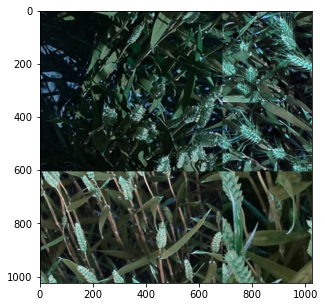

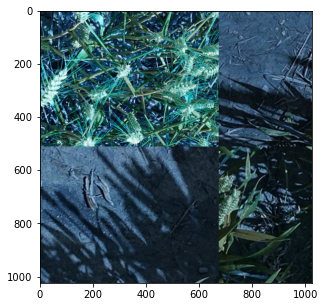

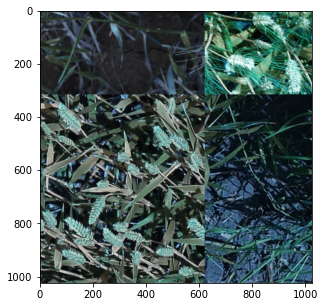

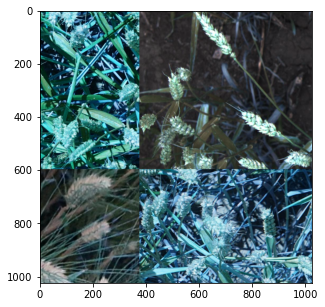

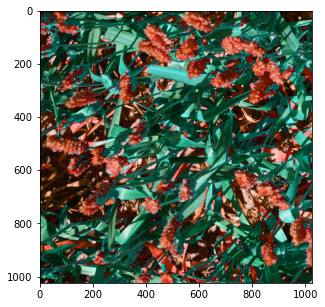

In [15]:
_ = next(iter(d))

# **Model - EfficientDet**

In [ ]:
def get_model(phi, score_threshold):
    model, prediction_model = efficientdet(phi,
                                       num_classes=1,
                                       weighted_bifpn=True,
                                       freeze_bn=True,
                                       score_threshold=score_threshold
                                       )
    
    model_name = 'efficientnet-b{}'.format(phi)
    file_name = '{}_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5'.format(model_name)
    file_hash = WEIGHTS_HASHES[model_name][1]
    weights_path = tf.keras.utils.get_file(file_name,
                                        BASE_WEIGHTS_PATH + file_name,
                                        cache_subdir='models',
                                        file_hash=file_hash)
    model.load_weights(weights_path, by_name=True)
    
    for i in range(1, [227, 329, 329, 374, 464, 566, 656][phi]):
        model.layers[i].trainable = False
    
    model.compile(optimizer=Adam(lr=1e-3), loss={
    'regression': smooth_l1(),
    'classification': focal()
    }, )
    
    return model, prediction_model


In [ ]:
phi = 4
score_threshold=0.4
batch_size = 4

In [ ]:
## model - training
# kf = KFold(n_splits=3, shuffle = True, random_state = 25)
# for fold, (train_img_index, val_img_index) in enumerate(kf.split(image_ids_list)):
#     model, predm = get_model(phi, score_threshold)
#     print("************************")
#     print("FOLD - ", fold)
#     print("************************")
#     t_img_ids = image_ids_list[train_img_index]
#     v_img_ids = image_ids_list[val_img_index]
#     with open(f"/kaggle/working/fold_{fold}_tr_ids.txt", "wb") as fp:   
#        pickle.dump(t_img_ids, fp)
#     with open(f"/kaggle/working/fold_{fold}_v_ids.txt", "wb") as fp:   
#        pickle.dump(v_img_ids, fp)
#     train_data_gen = DataGenerator(phi, marking, t_img_ids, batch_size, True)
#     val_data_gen   = DataGenerator(phi, marking, v_img_ids, batch_size, False)
#     history = model.fit(train_data_gen, epochs = 15, batch_size=batch_size, validation_data = val_data_gen, verbose = 1)
#     model.save(f"/kaggle/working/fold_{fold}_weights.h5")
#     break


# **Post-Processing**

In [10]:
def deaug_90(t_boxes, image_size = 1024):
    res_boxes = t_boxes.copy()
    res_boxes[:, [0,2]] = image_size - t_boxes[:, [3,1]] 
    res_boxes[:, [1,3]] = t_boxes[:, [0,2]]
    return res_boxes

def deaug_vertical_flip(t_boxes, image_size = 1024):
    t_boxes[:, [1,3]] = image_size - t_boxes[:, [3,1]]
    return t_boxes

def deaug_hori_flip(t_boxes, image_size = 1024):
    t_boxes[:, [0,2]] = image_size - t_boxes[:, [2,0]]
    return t_boxes

In [21]:
def postprocess_boxes_scores(boxes, scores, height, width):
    c_boxes = boxes.copy()
    c_scores = scores.copy()

    c_boxes[:, 0] = (np.clip(c_boxes[:, 0], 0, width - 1))/1024
    c_boxes[:, 1] = (np.clip(c_boxes[:, 1], 0, height - 1))/1024
    c_boxes[:, 2] = (np.clip(c_boxes[:, 2], 0, width - 1))/1024
    c_boxes[:, 3] = (np.clip(c_boxes[:, 3], 0, height - 1))/1024

    c_scores = np.clip(c_scores, 0, 1)
    return c_boxes, c_scores

In [22]:
def wbf(image, weights_list, iou_thr=0.5, skip_box_thr=0.0001):
    img = image.copy()
    
    boxes_list  = []
    scores_list = []
    labels_list = []
    for weights in weights_list:
        prediction_model.load_weights(weights, by_name=True)
        
        #rotate 90
        image = np.asarray(tf.image.rot90(img))
        boxes, scores, labels = prediction_model.predict_on_batch([np.expand_dims(image, axis=0)])
        boxes, scores, labels = np.squeeze(boxes), np.squeeze(scores), np.squeeze(labels)
        boxes = boxes.astype(int)
        boxes_1 = deaug_90(boxes)
        boxes, scores = postprocess_boxes_scores(boxes=(boxes_1).astype(float), scores = scores, height=h, width=w)
        boxes_list.append(boxes)
        scores_list.append(scores)
        labels_list.append(labels)

    
        #horizontal flip
        image = np.asarray(tf.image.flip_left_right(img))
        boxes, scores, labels = prediction_model.predict_on_batch([np.expand_dims(image, axis=0)])
        boxes, scores, labels = np.squeeze(boxes), np.squeeze(scores), np.squeeze(labels)
        boxes = boxes.astype(int)
        boxes_1 = deaug_hori_flip(boxes)
        boxes, scores = postprocess_boxes_scores(boxes=(boxes_1).astype(float), scores = scores, height=h, width=w)
        boxes_list.append(boxes)
        scores_list.append(scores)
        labels_list.append(labels)
        
        #vertical flip
        image = np.asarray(tf.image.flip_up_down(img))
        boxes, scores, labels = prediction_model.predict_on_batch([np.expand_dims(image, axis=0)])
        boxes, scores, labels = np.squeeze(boxes), np.squeeze(scores), np.squeeze(labels)
        boxes = boxes.astype(int)
        boxes_1 = deaug_vertical_flip(boxes)
        boxes, scores = postprocess_boxes_scores(boxes=(boxes_1).astype(float), scores = scores, height=h, width=w)
        boxes_list.append(boxes)
        scores_list.append(scores)
        labels_list.append(labels)

    boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(1024)
    return boxes, scores, labels

In [23]:
model, prediction_model = efficientdet(phi,
                                       num_classes=1,
                                       weighted_bifpn=True,
                                       freeze_bn=True,
                                       score_threshold=score_threshold
                                       )

In [24]:
weights_list = ['/kaggle/input/gwd-weights/fold_0_weights.h5', 
                '/kaggle/input/gwd-weights/fold_1_weights.hdf5', 
                '/kaggle/input/gwd-weights/fold_2_weights.h5',
                '/kaggle/input/gwd-weights/fold_3_weights.h5',
                '/kaggle/input/gwd-weights/fold_4_weights.h5']

In [52]:
%%time

score_threshold = 0.4
result_data = []
for n, image_path in notebook.tqdm(enumerate(glob.glob('/kaggle/input/global-wheat-detection/test/*.jpg'))):
    image_name = image_path.split('/')[-1]
    image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (1024, 1024))
    src_image = image.copy()
    h, w = image.shape[:2]
    image = image / 255.0   
    boxes, scores, labels= wbf(image, weights_list)
    indices = np.where(scores[:] > score_threshold)[0]
    boxes = boxes[indices]    
    row = [image_name.replace('.jpg','')]
    r_boxes = ""
    for s,b in zip(scores, boxes):
        if r_boxes != "":
            r_boxes += " "
        r_boxes += f"{round(float(s),4)} {int(b[0])} {int(b[1])} {int(b[2]-b[0])} {int(b[3]-b[1])}"
    row.append(r_boxes)
    result_data.append(row)

test_df = pd.DataFrame(result_data, columns=['image_id','PredictionString'])


CPU times: user 1min 9s, sys: 10.9 s, total: 1min 20s
Wall time: 1min 20s


In [53]:
test_df

image_id                                   PredictionString
0  cc3532ff6  0.9719 263 637 102 169 0.9714 768 825 169 168 ...
1  796707dd7  0.9376 706 824 113 102 0.9329 896 331 109 91 0...
2  53f253011  0.9728 615 98 126 151 0.9701 14 34 141 106 0.9...
3  51f1be19e  0.8945 497 464 208 107 0.893 608 93 153 163 0....
4  f5a1f0358  0.9422 689 201 113 95 0.9386 442 294 105 192 0...
5  2fd875eaa  0.9794 1 912 102 79 0.9788 394 793 73 89 0.971...
6  51b3e36ab  0.9693 231 636 100 167 0.9687 443 315 156 101 ...
7  348a992bb  0.9652 734 218 142 94 0.9548 136 39 117 86 0.9...
8  cb8d261a3  0.9628 22 557 181 107 0.9413 23 862 75 143 0.9...
9  aac893a91  0.9651 693 391 120 175 0.9603 242 86 136 144 0...

In [55]:
test_df_cp = test_df.copy()
ids = os.listdir("/kaggle/input/global-wheat-detection/test/")
test_ids = np.array(list(map(lambda x: x.split(".")[0], ids)))

def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
        
def score_chunks(lst1):
    for i in range(0, len(lst1)):
        yield lst1[i]
        
def display_output(test_df, name):
    test_df = test_df_cp.copy()
    pred_str = test_df['PredictionString'].copy()
    test_df['PredictionString'] = test_df['PredictionString'].apply(lambda a: a.split(' ')).apply(lambda myList: [x for i, x in enumerate(myList) if i%5 !=0])
    test_df['Score'] = pred_str.apply(lambda a: a.split(' ')).apply(lambda myList: [x for i, x in enumerate(myList) if i%5 ==0])
    
    lst1 = test_df[test_df['image_id'] == name]['PredictionString'].values[0]
    lst1 = list(map(int, lst1))     
    lst1_n = list(chunks(lst1, 4))
    
    lst2 = test_df[test_df['image_id'] == name]['Score'].values[0]
    lst2 = list(map(float, lst2))     
    lst2_n = list(score_chunks(lst2))
    
    sample = plt.imread('/kaggle/input/global-wheat-detection/test/' + name + '.jpg')
#     sample = np.array(tf.image.rot90(sample))
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    for box, score in zip(lst1_n, lst2_n):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2] + box[0], box[3] + box[1]),
                      (0, 0, 100), 2)
        cv2.putText(sample, '%.2f'%(score), (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2, cv2.LINE_AA)

    ax.set_axis_off()
    ax.imshow(sample)

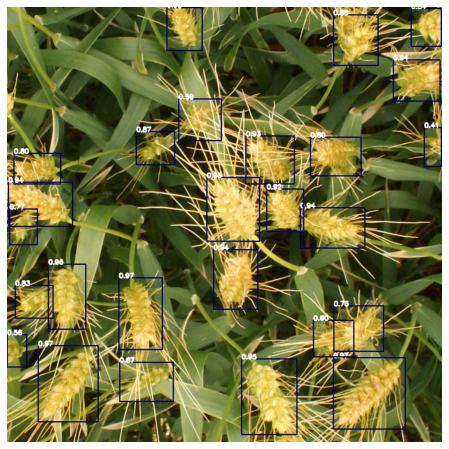

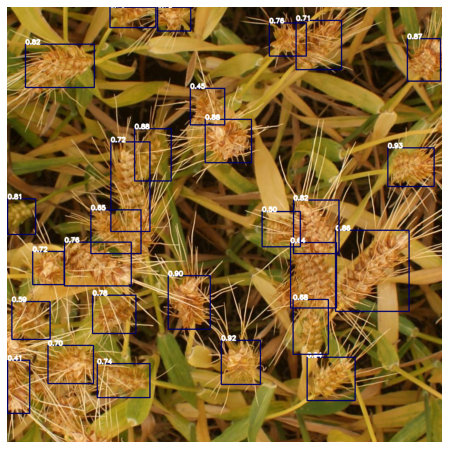

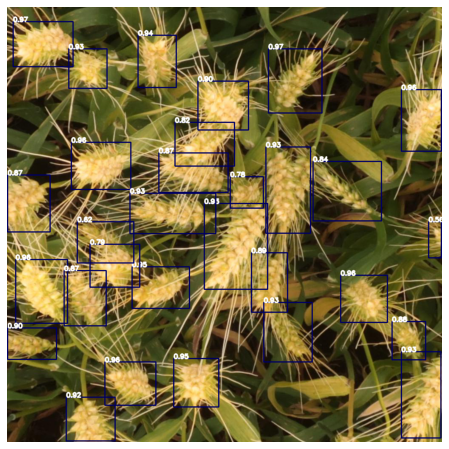

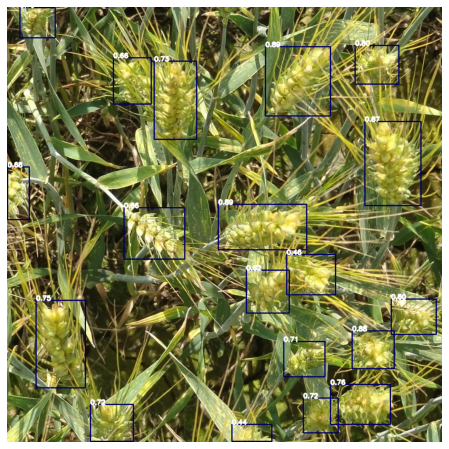

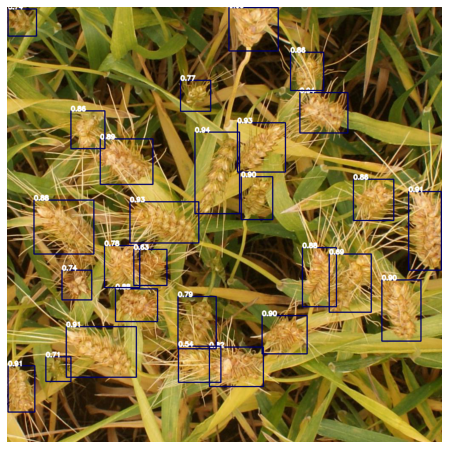

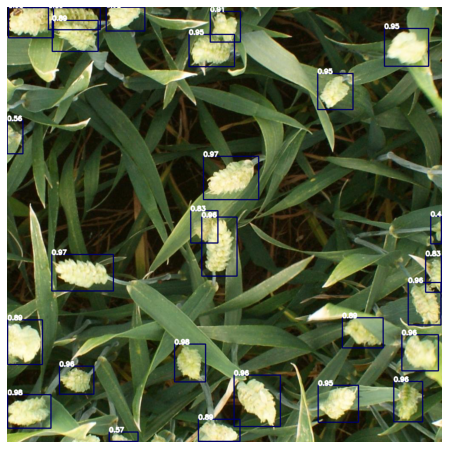

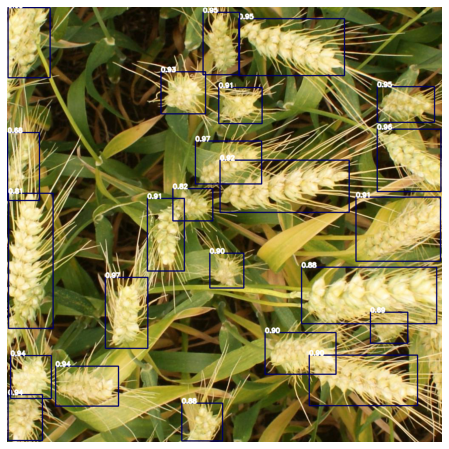

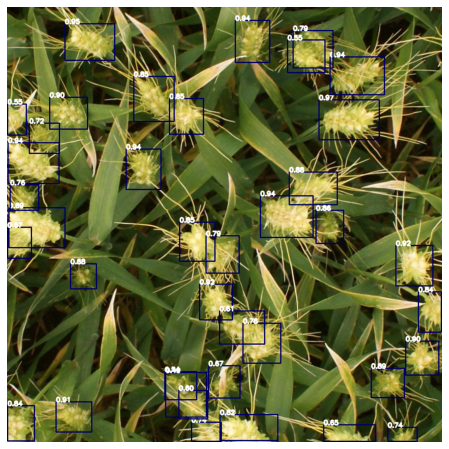

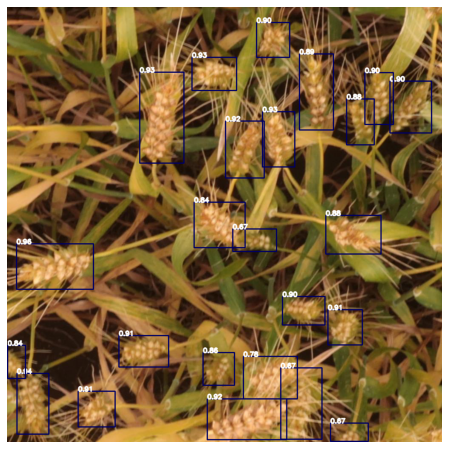

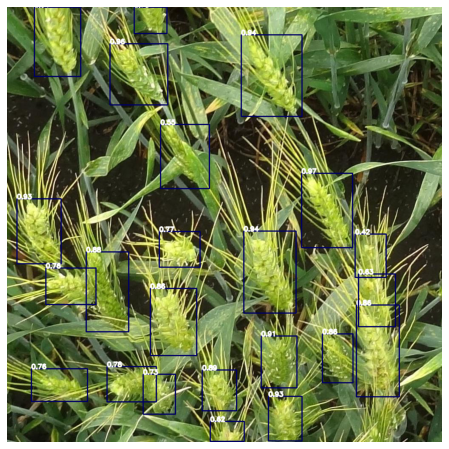

In [56]:
for name in test_ids:
    display_output(test_df, name)

**References**
* https://www.kaggle.com/shonenkov/wbf-approach-for-ensemble
* https://github.com/xuannianz/EfficientDet
* https://www.kaggle.com/shonenkov/oof-evaluation-mixup-efficientdet